In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
from scipy.stats import chi2
from sklearn.datasets import make_s_curve
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from iobs.layers import IOBLayer
from iobs.models import BaseAE

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print('Device:', device)
device='cpu'

Device: mps


# Generate dataset

In [3]:
# generate data
data, label = make_s_curve(
    n_samples=10000,
    noise=0.1
)

# center everything
data -= data.mean(axis=0)

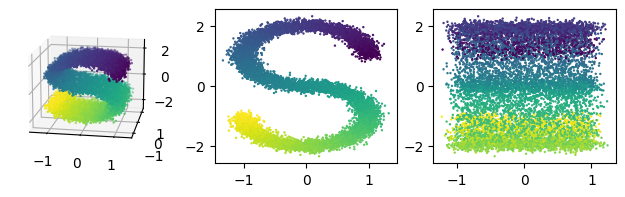

In [4]:
# plot dataset
f = plt.figure(figsize=(8,2))
gs = mpl.gridspec.GridSpec(1,3)

ax = f.add_subplot(gs[0,0], projection='3d')
ax.scatter(
    xs=data[:,0], 
    ys=data[:,1], 
    zs=data[:,2],
    rasterized=True, 
    c=label, s=0.5)
ax.view_init(elev=15., azim=-80)

ax = f.add_subplot(gs[0,1])
ax.scatter(
    x=data[:,0], 
    y=data[:,2],
    rasterized=True,
    c=label, s=0.5)

ax = f.add_subplot(gs[0,2])
ax.scatter(
    x=data[:,1], 
    y=data[:,2],
    rasterized=True,
    c=label, s=0.5)

In [5]:
# split into training, validation, and testing folds via 80-10-10
nfolds = 10
folds = np.random.choice(nfolds, size=len(data))

in_train = folds < nfolds-2
in_val = folds == nfolds-2
in_test = folds == nfolds-1

In [6]:
# create dataset and dataloaders
class SimulatedDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.data[idx])
        return self.data[idx]

train_dataset = SimulatedDataset(data[in_train])
val_dataset = SimulatedDataset(data[in_val])
test_dataset = SimulatedDataset(data[in_test])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define encoder-decoder architecture

In [7]:
def build_dense_sequence(shape_list):
    """Convenience function for building a sequence of dense (Linear) layers"""
    layers = []
    for i in range(len(shape_list) - 1):
        layers += [
            nn.Linear(shape_list[i], shape_list[i+1]),
            nn.ReLU()
        ]
    return layers[:-1]  # remove last ReLU

# define a fully-connected encoder
encoder = nn.Sequential(
    *(build_dense_sequence([3, 64, 64, 4])),
).to(device)

# define a fully-connected decoder
decoder = nn.Sequential(
    *(build_dense_sequence([4, 64, 64, 3])),
).to(device)

# define a IOB with a max width of 4 features
bottleneck = IOBLayer(4, device=device)

In [8]:
# build a simple autoencoder model
model = BaseAE(
    input_shape=(3,),
    encoder=encoder,
    decoder=decoder,
    bottleneck=bottleneck
)

In [9]:
# define a criterion for log-likelihood maximization
criterion = nn.MSELoss()

def lossfn(model, batch_features):
    """Loss function for averaging loss over all bottleneck widths evenly"""
    outputs = model.forward_all(batch_features)
    target = batch_features.unsqueeze(1).expand(*(outputs.shape))
    loss = criterion(outputs, target)
    return loss

# Train

In [10]:
# Set hyperparameters

# training
max_epochs = 3000
lr = 1e-4

# early stopping
min_change = 0.0001
patience = 20

optimizer = optim.Adam(model.parameters(), lr)

In [11]:
trloss_rec = []
valoss_rec = []
wait = 0
min_valoss = np.inf
for epoch in range(max_epochs):
    # train
    trloss = 0
    for batch_features in train_loader:
        batch_features = batch_features.float().to(device)
        optimizer.zero_grad()
        batch_loss = lossfn(model, batch_features)
        batch_loss.backward()
        optimizer.step()
        trloss += batch_loss.item()
    trloss = trloss / len(train_loader)

    # test
    with torch.no_grad():
        valoss = 0
        for batch_features in val_loader:
            batch_features = batch_features.float().to(device)
            batch_loss = lossfn(model, batch_features)
            valoss += batch_loss.item()
        valoss = valoss / len(val_loader)

    # record loss
    trloss_rec.append(trloss)
    valoss_rec.append(valoss)
    print(f"epoch : {epoch + 1}/{max_epochs}, "
          f"loss = {trloss:.6f}, val loss = {valoss:.6f}")
    
    # compute early stopping
    if valoss < min_valoss*(1-min_change):
        wait = 0
        min_valoss = valoss
    else:
        wait += 1
    if wait >= patience:
        print(f'Early stopping at epoch {epoch + 1}/{max_epochs}')
        break

epoch : 1/3000, loss = 0.886567, val loss = 0.801607
epoch : 2/3000, loss = 0.604911, val loss = 0.455425
epoch : 3/3000, loss = 0.435698, val loss = 0.417314
epoch : 4/3000, loss = 0.407237, val loss = 0.392017
epoch : 5/3000, loss = 0.377377, val loss = 0.353543
epoch : 6/3000, loss = 0.337038, val loss = 0.313309
epoch : 7/3000, loss = 0.294047, val loss = 0.279268
epoch : 8/3000, loss = 0.275208, val loss = 0.272610
epoch : 9/3000, loss = 0.270251, val loss = 0.268490
epoch : 10/3000, loss = 0.266885, val loss = 0.265422
epoch : 11/3000, loss = 0.263862, val loss = 0.262757
epoch : 12/3000, loss = 0.261291, val loss = 0.260168
epoch : 13/3000, loss = 0.258714, val loss = 0.258024
epoch : 14/3000, loss = 0.256456, val loss = 0.255968
epoch : 15/3000, loss = 0.254195, val loss = 0.253569
epoch : 16/3000, loss = 0.252132, val loss = 0.251536
epoch : 17/3000, loss = 0.249949, val loss = 0.249473
epoch : 18/3000, loss = 0.247690, val loss = 0.247547
epoch : 19/3000, loss = 0.245622, val

epoch : 152/3000, loss = 0.211126, val loss = 0.213348
epoch : 153/3000, loss = 0.211151, val loss = 0.213372
epoch : 154/3000, loss = 0.211041, val loss = 0.213514
epoch : 155/3000, loss = 0.211139, val loss = 0.213327
epoch : 156/3000, loss = 0.211139, val loss = 0.213315
epoch : 157/3000, loss = 0.211083, val loss = 0.213447
epoch : 158/3000, loss = 0.211152, val loss = 0.213313
epoch : 159/3000, loss = 0.211235, val loss = 0.213559
epoch : 160/3000, loss = 0.211096, val loss = 0.213340
epoch : 161/3000, loss = 0.210956, val loss = 0.213317
epoch : 162/3000, loss = 0.211154, val loss = 0.213317
epoch : 163/3000, loss = 0.211065, val loss = 0.213260
epoch : 164/3000, loss = 0.211095, val loss = 0.213292
epoch : 165/3000, loss = 0.210912, val loss = 0.213280
epoch : 166/3000, loss = 0.211090, val loss = 0.213238
epoch : 167/3000, loss = 0.211171, val loss = 0.213278
epoch : 168/3000, loss = 0.211082, val loss = 0.213433
epoch : 169/3000, loss = 0.211016, val loss = 0.213401
epoch : 17

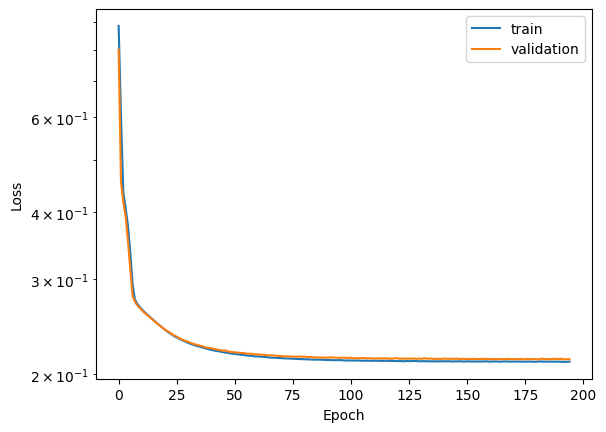

In [12]:
# plot loss vs. time
lenrec = len(trloss_rec)

f, ax = plt.subplots()
ax.semilogy()
ax.plot(range(lenrec), trloss_rec, label='train')
ax.plot(range(lenrec), valoss_rec, label='validation')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend()

# Test

In [13]:
# embed and reconstruct all test images, for all possible bottleneck widths
test_data = test_dataset.data
test_label = label[in_test]
recon_data = np.zeros_like(test_data)
recon_data = np.repeat(recon_data[:,None,...], repeats=model.latent_dim+1, axis=1)
with torch.no_grad():
    i = 0
    for j, batch_features in enumerate(test_loader):
        batch_features = batch_features.float().to(device)
        recon_data[i:i+len(batch_features)] = \
            model.forward_all(batch_features).detach().cpu()
        i += len(batch_features)

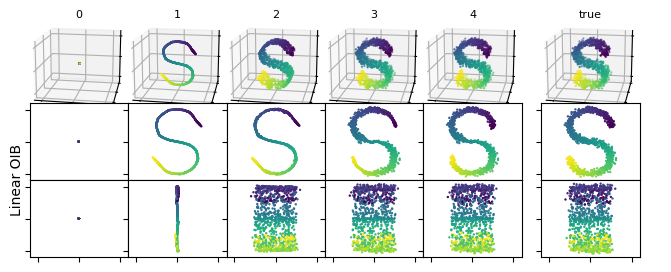

In [14]:
# show reconstruction examples, as a function of bottleneck width
lmin = test_data.min()*1.1
lmax = test_data.max()*1.1

def plot3d(data, label, gsax):
    ax = fig.add_subplot(gsax, projection='3d')
    ax.scatter(
        xs=data[:,0], 
        ys=data[:,1], 
        zs=data[:,2], 
        rasterized=True,  
        c=label, s=0.5)
    ax.set_xlim(lmin, lmax)
    ax.set_ylim(lmin, lmax)
    ax.set_zlim(lmin, lmax)
    ax.view_init(elev=15., azim=-80)
    ax.set_box_aspect(None, zoom=1.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    return ax

def plot2d(data, label, gsax):
    ax = fig.add_subplot(gsax)
    ax.scatter(
        x=data[:, 0], 
        y=data[:, 1],
        rasterized=True,    
        c=label, s=0.5)
    ax.set_xlim(lmin, lmax)
    ax.set_ylim(lmin, lmax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return gsax

fig = plt.figure(figsize=(8,3))
gs = mpl.gridspec.GridSpec(3,8, hspace=0, wspace=0,
                           width_ratios=[1]+[10]*5+[2,10])

ax = fig.add_subplot(gs[1:,0])
ax.axis('off')
ax.text(-1,0.5,'Linear OIB', va='center', ha='left', rotation=90)

# plot Linear
for i in range(1, 6):
    ax = plot3d(recon_data[:,i-1,:], test_label, gs[0,i])
    ax.set_title(i-1, fontsize=8)
    
    ax = plot2d(recon_data[:,i-1,[0,2]], test_label, gs[1,i])
    ax = plot2d(recon_data[:,i-1,[1,2]], test_label, gs[2,i])

# plot true
ax = plot3d(test_data, test_label, gs[0,-1])
ax.set_title('true', fontsize=8)

ax = plot2d(test_data[:,[0,2]], test_label, gs[1,-1])
ax = plot2d(test_data[:,[1,2]], test_label, gs[2,-1])

Text(0, 0.5, '$\\mathrm{MSE}/\\sigma^2_\\mathrm{pop}$')

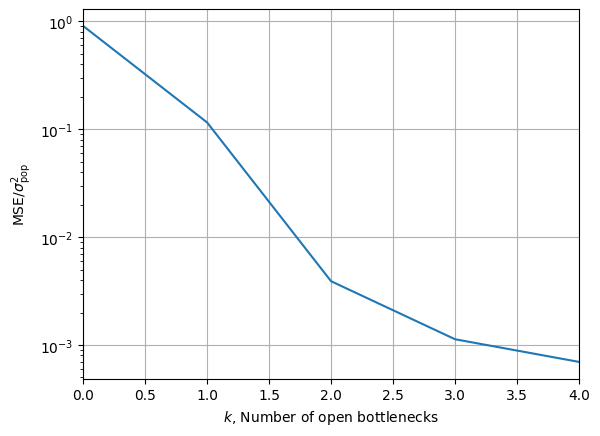

In [15]:
# calculate and plot the % variance explained, as a function of bottlneeck width
testvar = np.sum(np.var(test_data, axis=0).shape)
test_percerr = np.sum(np.mean((recon_data-test_data[:,None])**2, axis=0), axis=(1))/testvar

f,ax = plt.subplots()
ax.semilogy()
ax.plot(test_percerr)
ax.grid()
ax.set_xlim(0, model.latent_dim)
ax.set_xlabel('$k$, Number of open bottlenecks')
ax.set_ylabel('$\mathrm{MSE}/\sigma^2_\mathrm{pop}$')

# Calculate intrinsic dimensionality

In [16]:
# calculate intrinisic dimensionality

p = 0.05  # p-value at which to reject the null hypothesis
diff_loglik = -np.diff(test_percerr/2)*len(test_data)
intdim = np.argwhere(diff_loglik<chi2.isf(p,1))[0,0]
print(f'Intrinsic Dimensionality: {intdim}')

Intrinsic Dimensionality: 2
